# Textract Textractor 

Textractor helps accelerate your PoCs by allowing you to quickly extract text, forms and tables from documents using Amazon Textract. It can generate output in different formats including raw JSON, JSON for each page in a document, text, text in reading order, key/values exported as CSV, and tables exported as CSV.

In this notebook, you'll be using various packages for different features. The repository can be found here https://github.com/aws-samples/amazon-textract-textractor. All packages are also available on PyPI.

Ensure you're using the **conda_mxnet_latest_p37** kernel. **Python 3.7** is required to run the code. 

First, you'll upgrade to the latest version of textract-helper https://github.com/aws-samples/amazon-textract-textractor/tree/master/helper. Helper also use the caller, overlayer and pretty-printer methods.

In [1]:
!python -m pip install -q amazon-textract-caller --upgrade
!python -m pip install -q amazon-textract-response-parser --upgrade

You should consider upgrading via the '/Users/schadem/.pyenv/versions/3.9.6/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/schadem/.pyenv/versions/3.9.6/bin/python -m pip install --upgrade pip' command.


In [2]:
import boto3
import trp
import trp.trp2 as t2
# Textract Caller
from textractcaller.t_call import call_textract, Textract_Features
# Textract Response Parser
from trp import Document

In [3]:
# Amazon Textract client
textract = boto3.client('textract')

#Document
documentName = "employmentapp.png"

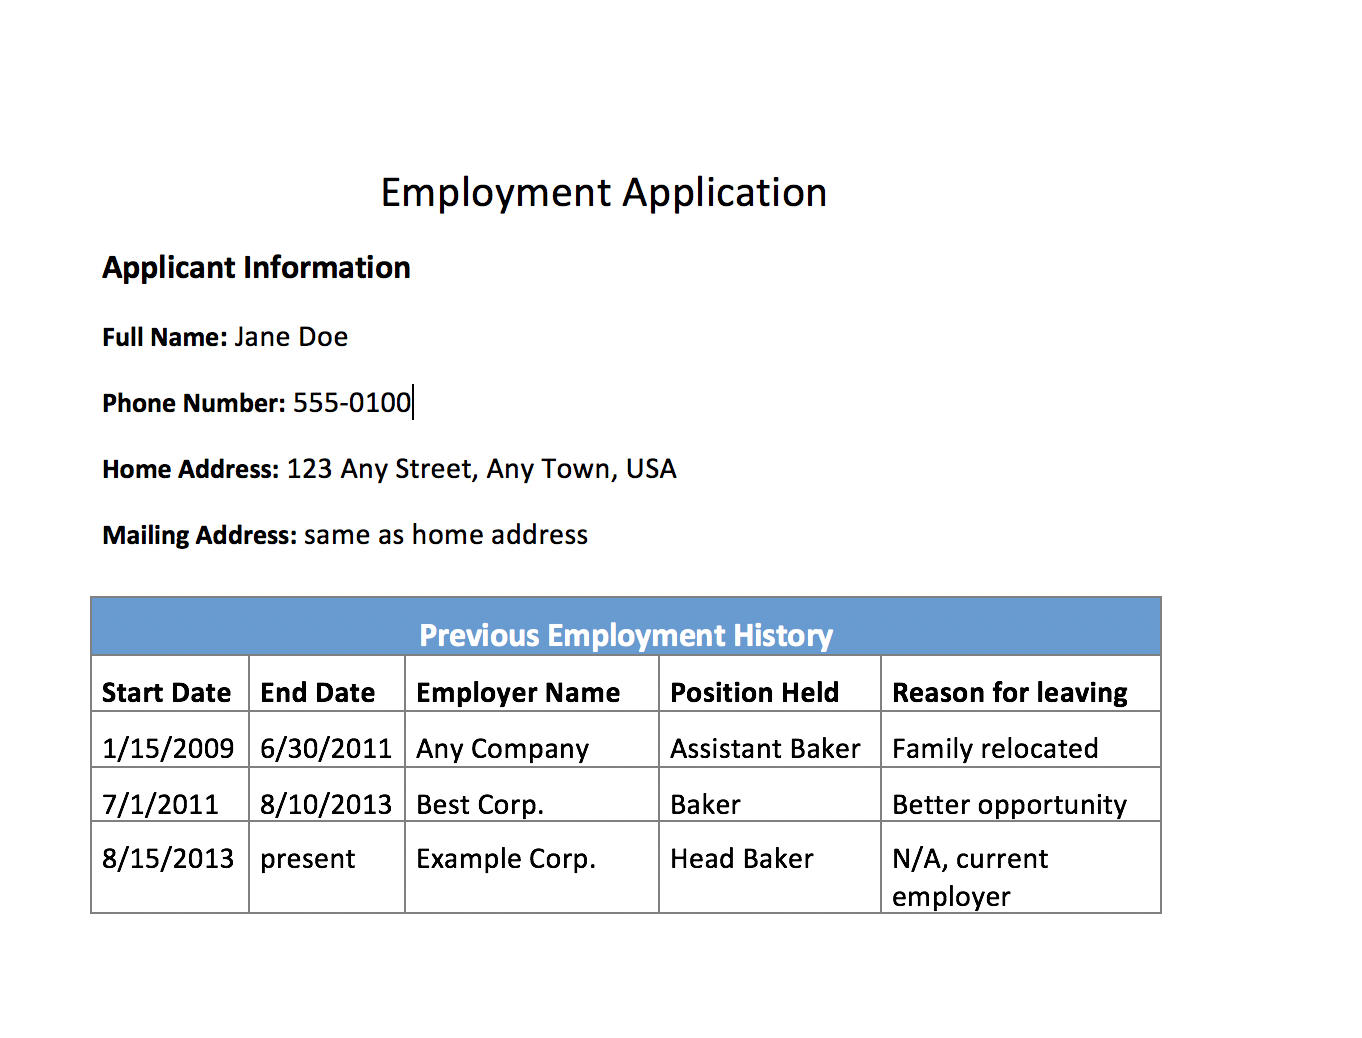

In [4]:
#display the document
from IPython.display import Image
Image(documentName)

# Textract Overlayer 

Textract overlayer generates bounding boxes to make it easier to draw for visualizations.

In [5]:
!python -m pip install -q amazon-textract-overlayer 

You should consider upgrading via the '/Users/schadem/.pyenv/versions/3.9.6/bin/python -m pip install --upgrade pip' command.


In [6]:
from PIL import Image as PImage, ImageDraw
image = PImage.open(documentName)

#use textract caller and overlayer to get bounding boxes
from textractoverlayer.t_overlay import DocumentDimensions, get_bounding_boxes
from textractcaller.t_call import Textract_Features, Textract_Types, call_textract


doc = call_textract(input_document = documentName, features = [Textract_Features.FORMS, Textract_Features.TABLES])

# image is a PIL.Image.Image in this case
document_dimension:DocumentDimensions = DocumentDimensions(doc_width=image.size[0], doc_height=image.size[1])
    
#return the bounding boxes for word, form, and cell types
overlay=[Textract_Types.WORD, Textract_Types.FORM, Textract_Types.CELL]

bounding_box_list = get_bounding_boxes(textract_json=doc, document_dimensions=document_dimension, overlay_features=overlay)

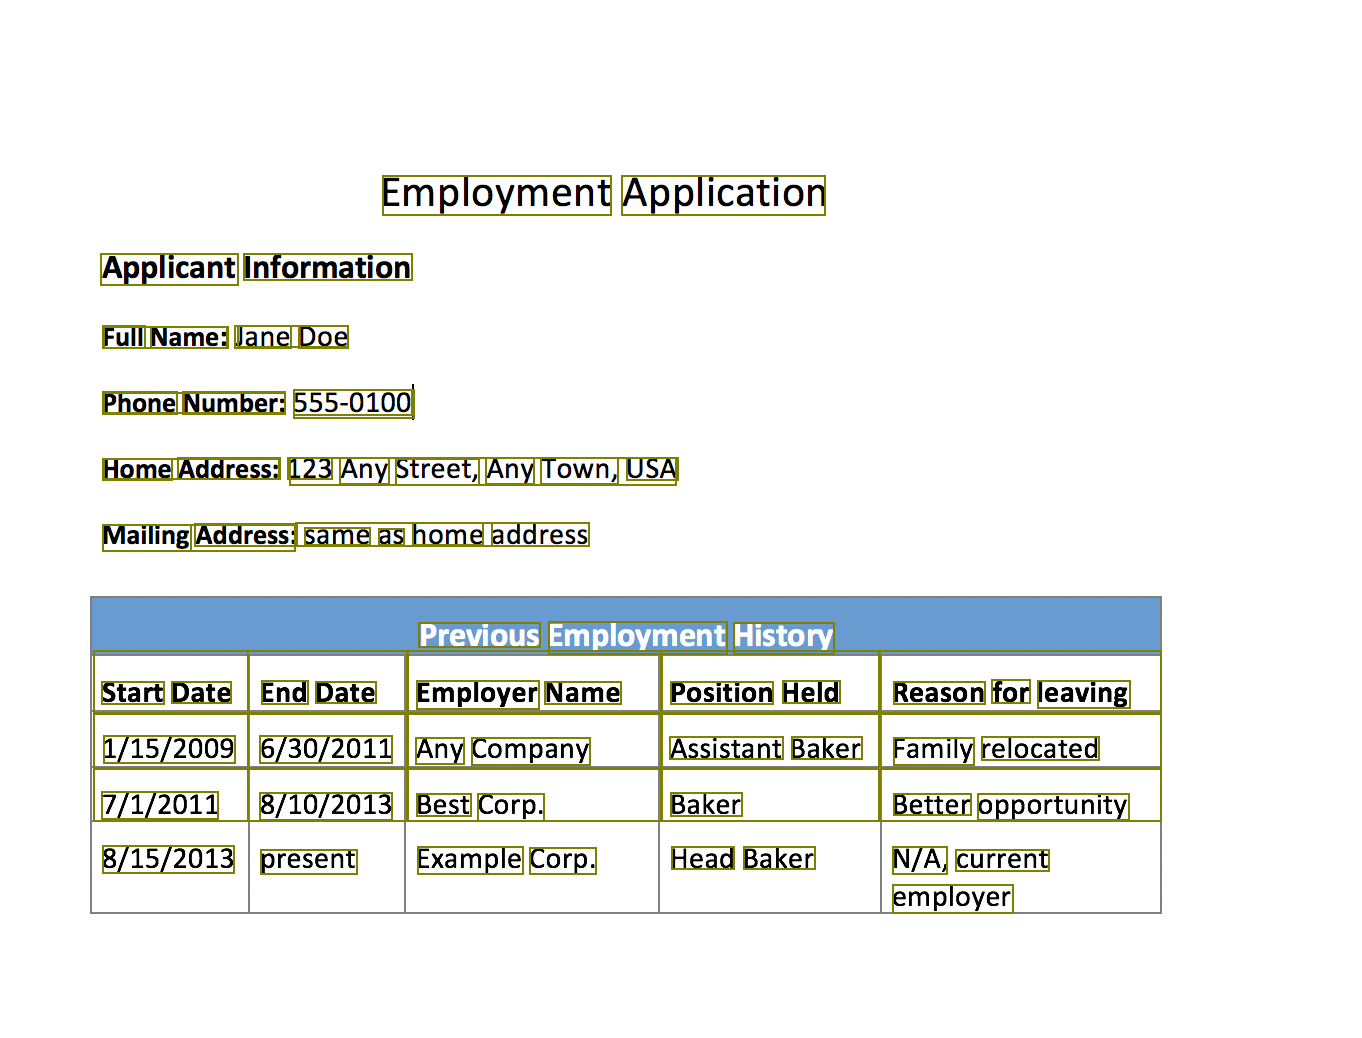

In [17]:
#Show the overlay drawing of the bounding boxes on the document
rgb_im = image.convert('RGB')
draw = ImageDraw.Draw(rgb_im)

# check the implementation in amazon-textract-helper for ways to associate different colors to types
for bbox in bounding_box_list:
    draw.rectangle(xy=[bbox.xmin, bbox.ymin, bbox.xmax, bbox.ymax], outline=(128, 128, 0), width=2)

from IPython.display import Image
display(rgb_im)

# Textract Response Parser

Use the Textract response parser library to parse the JSON returned by Textract. By default Textract does not put the elements identified in an order in the JSON response. This sample prints the elements in order and the confidence score.

In [8]:
# Call Amazon Textract
response = call_textract(input_document = documentName, 
                         features = [Textract_Features.FORMS, Textract_Features.TABLES])

from trp import Document
doc = Document(response)

# Iterate over elements in the document
for page in doc.pages:
    # Print lines and words
    for line in page.lines:
        print("Line: {}--{}".format(line.text, line.confidence))
        for word in line.words:
            print("Word: {}--{}".format(word.text, word.confidence))

    # Print tables
    for table in page.tables:
        for r, row in enumerate(table.rows):
            for c, cell in enumerate(row.cells):
                print("Table[{}][{}] = {}-{}".format(r, c, cell.text, cell.confidence))

    # Print fields
    for field in page.form.fields:
        key = field.key.text if field.key else ""
        value = field.value.text if field.value else ""
        print("Field: Key: {}, Value: {}".format(key, value))

    # Get field by key
    key = "Phone Number:"
    field = page.form.getFieldByKey(key)
    if(field):
        print("Field: Key: {}, Value: {}".format(field.key, field.value))

    # Search fields by key
    key = "address"
    fields = page.form.searchFieldsByKey(key)
    for field in fields:
        print("Field: Key: {}, Value: {}".format(field.key, field.value))

Line: Employment Application--99.90126037597656
Word: Employment--99.89954376220703
Word: Application--99.9029769897461
Line: Applicant Information--99.57406616210938
Word: Applicant--99.81241607666016
Word: Information--99.33570861816406
Line: Full Name: Jane Doe--99.69449615478516
Word: Full--99.83560180664062
Word: Name:--99.53668212890625
Word: Jane--99.52113342285156
Word: Doe--99.88456726074219
Line: Phone Number: 555-0100--99.44634246826172
Word: Phone--99.3232650756836
Word: Number:--99.78343200683594
Word: 555-0100--99.23233032226562
Line: Home Address: 123 Any Street, Any Town, USA--99.79651641845703
Word: Home--99.57723999023438
Word: Address:--99.63672637939453
Word: 123--99.86543273925781
Word: Any--99.89830780029297
Word: Street,--99.74813079833984
Word: Any--99.88127136230469
Word: Town,--99.94439697265625
Word: USA--99.82061767578125
Line: Mailing Address: same as home address--99.8390884399414
Word: Mailing--99.86315155029297
Word: Address:--99.5790023803711
Word: same

## Order blocks (WORDS, LINES, TABLE, KEY_VALUE_SET) by geometry y-axis

The sample is similar to the above cell, but uses the order_blocks_by_geo function using the Serializer/Deserializer shows how to change the structure and order the elements while maintaining the schema. This way no change is necessary to integrate with existing processing.

In [9]:
#from textractcaller.t_call import call_textract, Textract_Features
from trp.trp2 import TDocument, TDocumentSchema
from trp.t_pipeline import order_blocks_by_geo
import trp


j = call_textract(input_document = documentName, features=[Textract_Features.FORMS, Textract_Features.TABLES])
# the t_doc will be not ordered
t_doc = TDocumentSchema().load(j)
# the ordered_doc has elements ordered by y-coordinate (top to bottom of page)
ordered_doc = order_blocks_by_geo(t_doc)
# send to trp for further processing logic
trp_doc = trp.Document(TDocumentSchema().dump(ordered_doc))
print(trp_doc)


Document
Page
Line
Employment Application
Words
----------
[Employment][Application]
Line
Applicant Information
Words
----------
[Applicant][Information]
Line
Full Name: Jane Doe
Words
----------
[Full][Name:][Jane][Doe]

Field
Key: Full Name:
Value: Jane Doe
Line
Phone Number: 555-0100
Words
----------
[Phone][Number:][555-0100]

Field
Key: Phone Number:
Value: 555-0100
Line
Home Address: 123 Any Street, Any Town, USA
Words
----------
[Home][Address:][123][Any][Street,][Any][Town,][USA]

Field
Key: Home Address:
Value: 123 Any Street, Any Town, USA
Line
Mailing Address: same as home address
Words
----------
[Mailing][Address:][same][as][home][address]

Field
Key: Mailing Address:
Value: same as home address
Line
Previous Employment History
Words
----------
[Previous][Employment][History]
Table
Row
[Start Date ][End Date ][Employer Name ][Position Held ][Reason for leaving ]
Row
[1/15/2009 ][6/30/2011 ][Any Company ][Assistant Baker ][Family relocated ]
Row
[7/1/2011 ][8/10/2013 ][Bes

# Textract Prettyprinter

Textract prettyprinter formats the Textract JSON output in an easier to read format that is more consumable to use in other systems e.g. CSV, LaTeX, Markdown. 

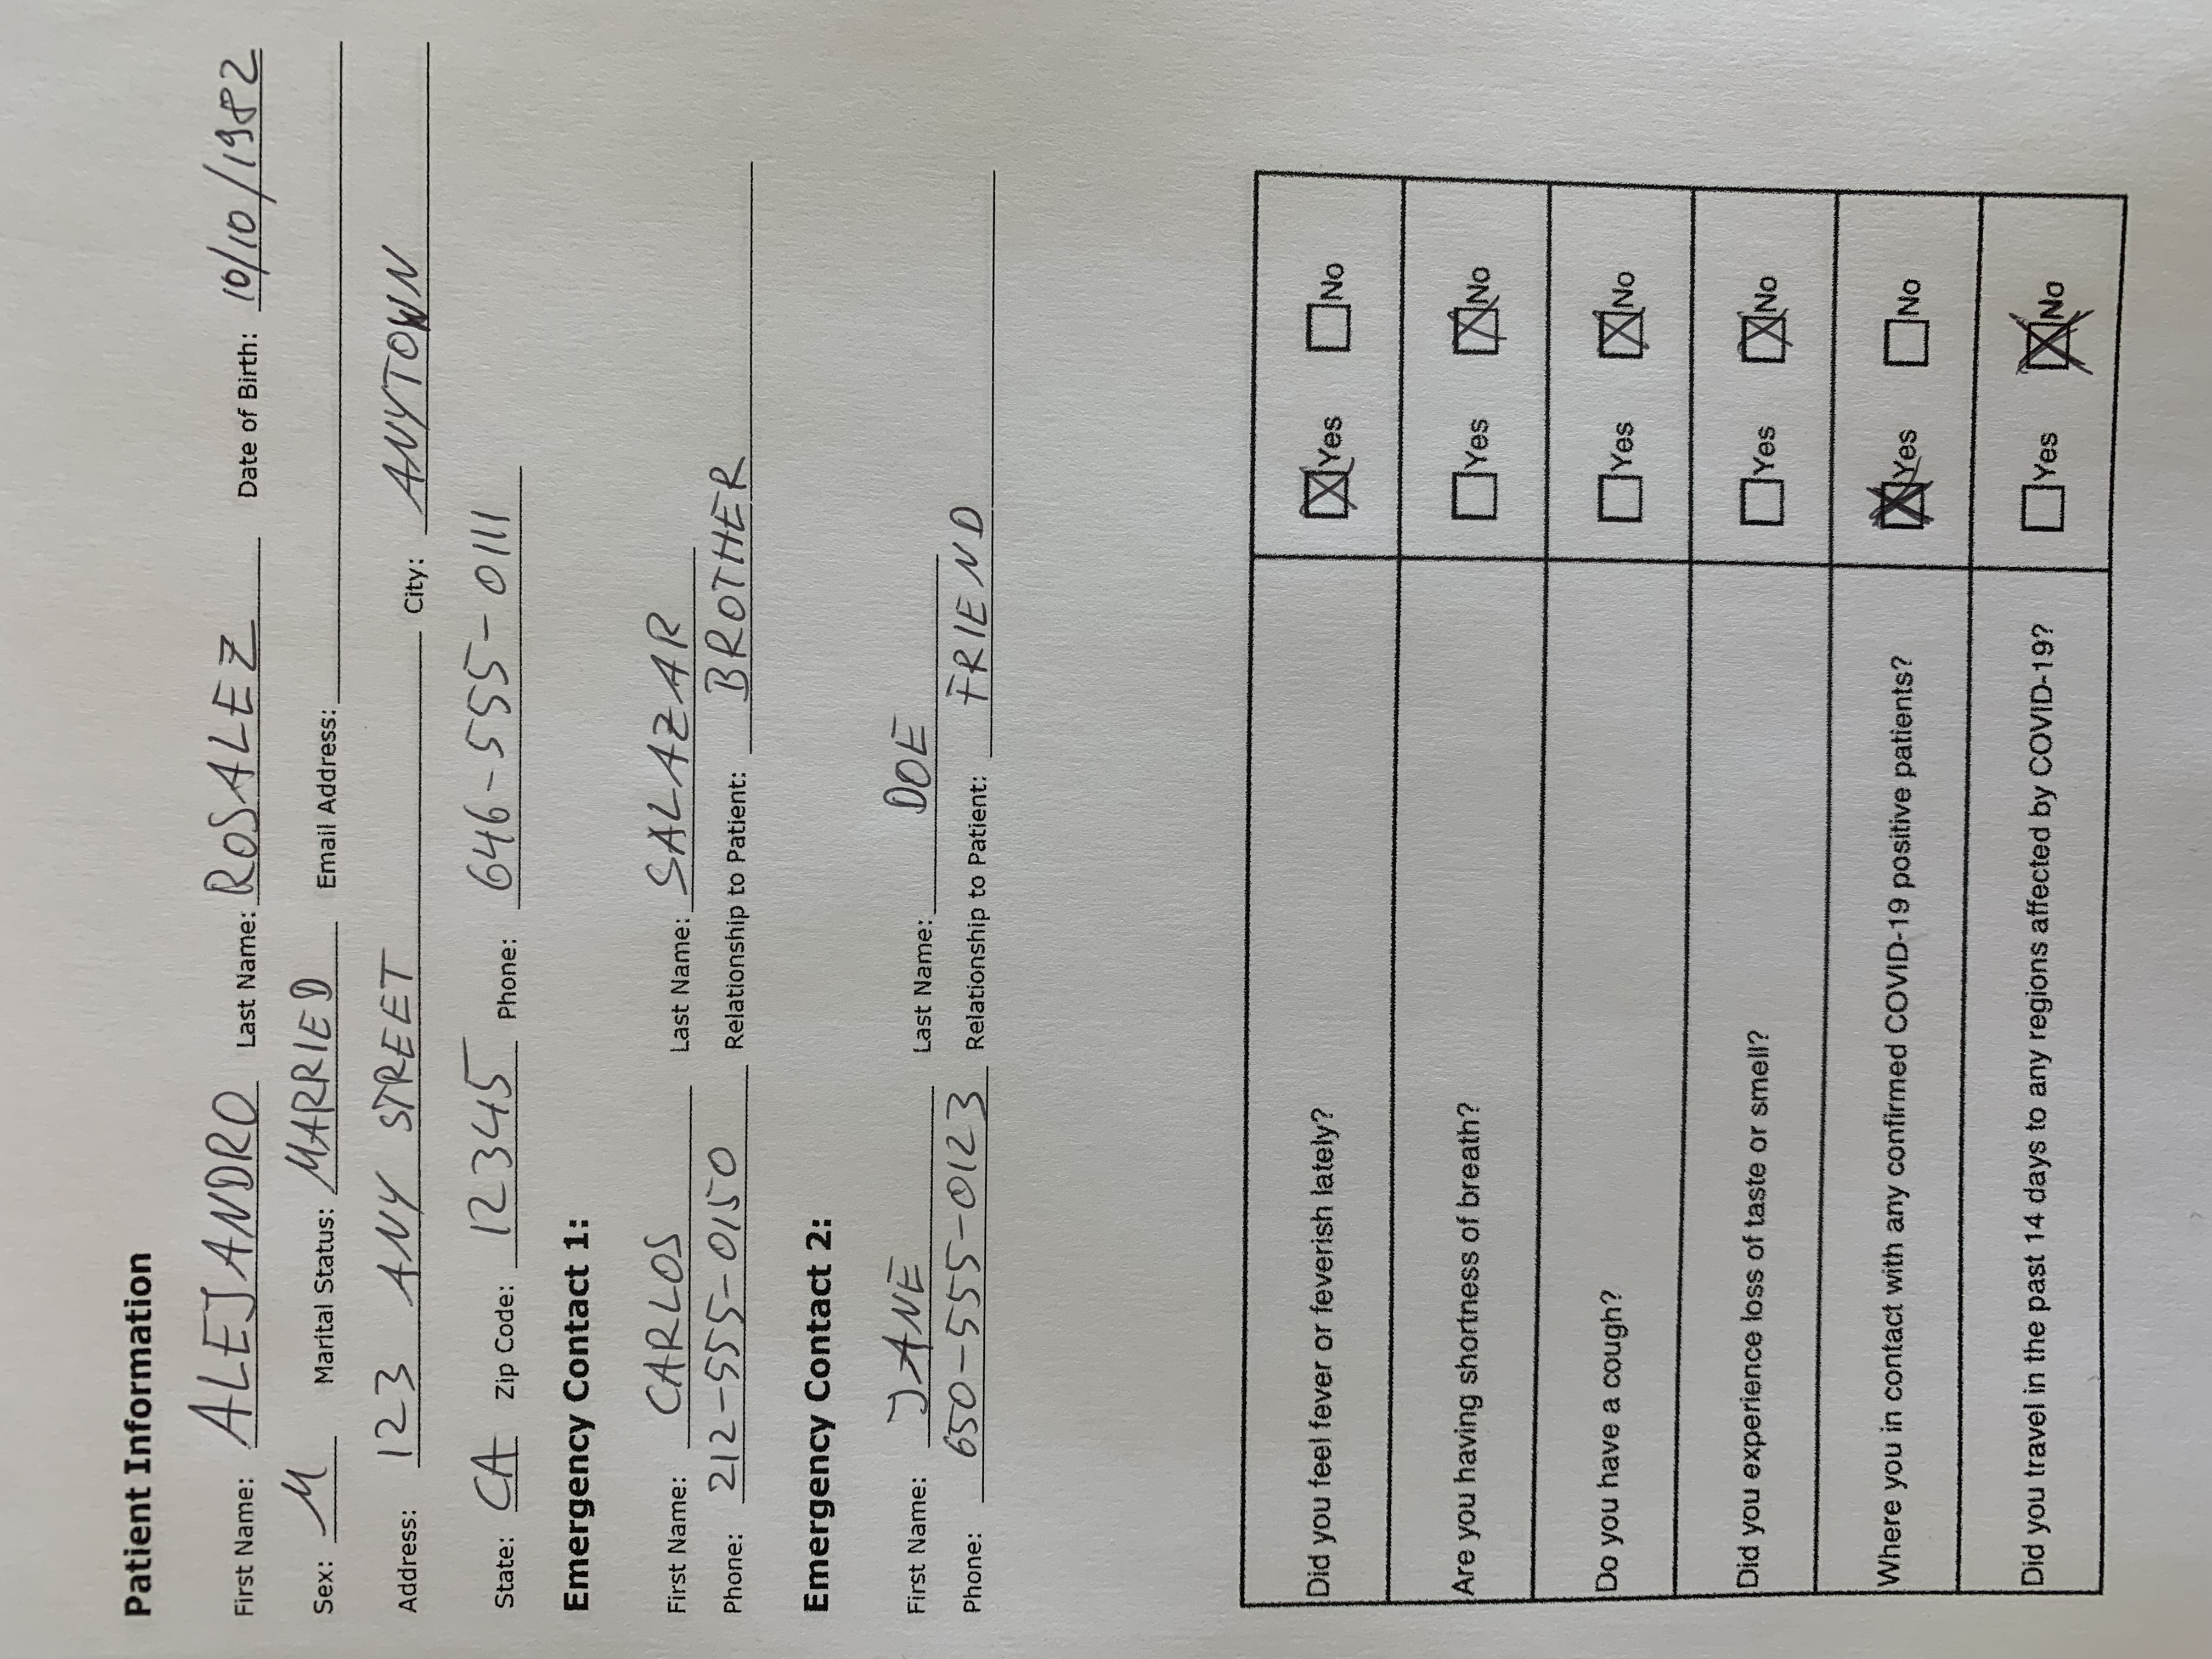

In [10]:
#new image
imageName="patient_intake_form_sample.jpg"

#display the image
from IPython.display import Image
Image(imageName)

In [11]:
#format Textract output and print in CSV format 
from textractprettyprinter.t_pretty_print import Pretty_Print_Table_Format, Textract_Pretty_Print, get_string, get_tables_string
from textractcaller.t_call import Textract_Features, Textract_Types, call_textract

textract_json = call_textract(input_document= imageName, features=[Textract_Features.FORMS, Textract_Features.TABLES])
print(get_string(textract_json=textract_json,
               table_format=Pretty_Print_Table_Format.csv,
               output_type=[Textract_Pretty_Print.FORMS, Textract_Pretty_Print.TABLES]))

Key,Value
First Name:,ALEJANDRO
First Name:,CARLOS
Relationship to Patient:,BROTHER
First Name:,JANE
Marital Status:,MARRIED
Phone:,646-555-0111
Last Name:,SALAZAR
Phone:,212-555-0150
Relationship to Patient:,FRIEND
Last Name:,ROSALEZ
City:,ANYTOWN
Phone:,650-555-0123
Address:,123 ANY STREET
Yes,SELECTED
Yes,NOT_SELECTED
Date of Birth:,10/10/1982
Last Name:,DOE
Sex:,M
Yes,NOT_SELECTED
Yes,NOT_SELECTED
Yes,NOT_SELECTED
State:,CA
Zip Code:,12345
Email Address:,
No,NOT_SELECTED
No,SELECTED
No,NOT_SELECTED
Yes,SELECTED
No,SELECTED
No,SELECTED
No,SELECTED

Did you feel fever or feverish lately? ,"NOT_SELECTED, SELECTED, Yes No "
Are you having shortness of breath? ,"NOT_SELECTED, SELECTED, Yes No "
Do you have a cough? ,"NOT_SELECTED, SELECTED, Yes No "
Did you experience loss of taste or smell? ,"NOT_SELECTED, SELECTED, Yes No "
Where you in contact with any confirmed COVID-19 positive patients? ,"NOT_SELECTED, SELECTED, Yes No "




In [12]:
#call Textract
j = call_textract(input_document=imageName, features=[Textract_Features.FORMS])

#Print the key/value pairs to identify the ones that have the same name. 
from textractprettyprinter.t_pretty_print import get_forms_string
print(get_forms_string(j))

|--------------------------|----------------|
| Key                      | Value          |
| First Name:              | ALEJANDRO      |
| First Name:              | CARLOS         |
| Relationship to Patient: | BROTHER        |
| First Name:              | JANE           |
| Marital Status:          | MARRIED        |
| Phone:                   | 646-555-0111   |
| Last Name:               | SALAZAR        |
| Phone:                   | 212-555-0150   |
| Relationship to Patient: | FRIEND         |
| Last Name:               | ROSALEZ        |
| City:                    | ANYTOWN        |
| Phone:                   | 650-555-0123   |
| Address:                 | 123 ANY STREET |
| Yes                      | SELECTED       |
| Yes                      | NOT_SELECTED   |
| Date of Birth:           | 10/10/1982     |
| Last Name:               | DOE            |
| Sex:                     | M              |
| Yes                      | NOT_SELECTED   |
| Yes                      | NOT_S